In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from PIL import Image
import glob
import json
from matplotlib import pyplot as plt
import os
from composite_coco import *
from tqdm import tqdm
import cv2
import albumentations as A
import pandas as pd
import random

import shutil
from sahi.utils.file import load_json, save_json
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation, merge_from_list
from sahi.utils.cv import get_coco_segmentation_from_bool_mask, get_bbox_from_bool_mask
from sklearn.model_selection import GroupKFold

# A brief summary of generated datasets

```augmented_defect_library```: augmented element defect library

```augmented_training_set```: augmented training set in original annotation format

```augmented_training_setdemo```: augmented training set with annotation on the image (for visualization)

```generated_synthetic_defect_dataset```: final coco version of generated synthetic defect dataset


# First load image path as well as annotations based on which we want to generate more synthetic defect

In [3]:
data_name = 'Lenses'
image_path = "./Datasets/"+data_name+"/train/"
annFile = "./Datasets/"+data_name+"/train/_annotations.coco.json"
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Next we will use syntehtic defect generation pipeline to augment the TRAINING set 

## Prepare defects and save in the "output_defect_source_dir" 
The defect annotation file is saved as 'output_defect_source_dir/training_defect_library_annotations.json'

In [4]:
work_dir = './SYnthetic_data_generation_results/'+data_name+'/'
output_defect_source_dir = work_dir +'training_defect_sources/'
defect_source_prep(image_path, coco, output_defect_source_dir)

preparing_defect_images: 100%|██████████| 31/31 [01:03<00:00,  2.06s/it]


## Augment defects from "output_defect_source_dir" and save as "augmented_defect_dir"

In [6]:
defects_path = output_defect_source_dir
defect_annotation_file = output_defect_source_dir+'training_defect_library_annotations.json'
augmented_defect_dir = work_dir +'augmented_defect_library/'
augment_cat = [] # the category of defect that we want to augment, here [] measn augment all; if you want to augment multiple classes of defect, an example is  ['Collision','scratch']
augment_cat_Ids = coco.getCatIds(catNms=augment_cat) # get catIdes
augment(work_dir, defects_path, defect_annotation_file, augmented_defect_dir, augment_cat_Ids)

augmenting_defect_images:   2%|▏         | 2/85 [00:21<15:39, 11.31s/it]/Users/sean/Documents/GitHub/Syn/composite_coco.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segmentation = np.array([np.array(poly) for poly in segs_after_transform])# this has to be a list of arrays, each array is an annotation
augmenting_defect_images: 100%|██████████| 85/85 [22:40<00:00, 16.01s/it]


## Generate new dataset: the generated synthetic images and annotations will be store at "augmented_training_set"

In [7]:
# defects
work_dir = './SYnthetic_data_generation_results/'+data_name+'/'
augmented_defect_dir = work_dir +'augmented_defect_library/'
defects_path = augmented_defect_dir
# The generated synthetic images and annotations will be stored in the following paths 
defect_annotation_file = defects_path+'augmented_training_defect_library_annotations.json'
output_path = work_dir+'augmented_training_set/'
coco_bkg = coco #annotations for input background images
agument_per_image = 10 # how many images are agumented from one input background image
num_def_per_img = 5 # how many defects generated per image 
generate_new_dataset(image_path, coco_bkg, defects_path, defect_annotation_file, output_path,  num_def_per_img = num_def_per_img, agument_per_image = agument_per_image)

Generating_synthetic_defect_image_dataset: 100%|██████████| 31/31 [12:40<00:00, 24.52s/it]


# Sanity check

## Check the defect library augment result

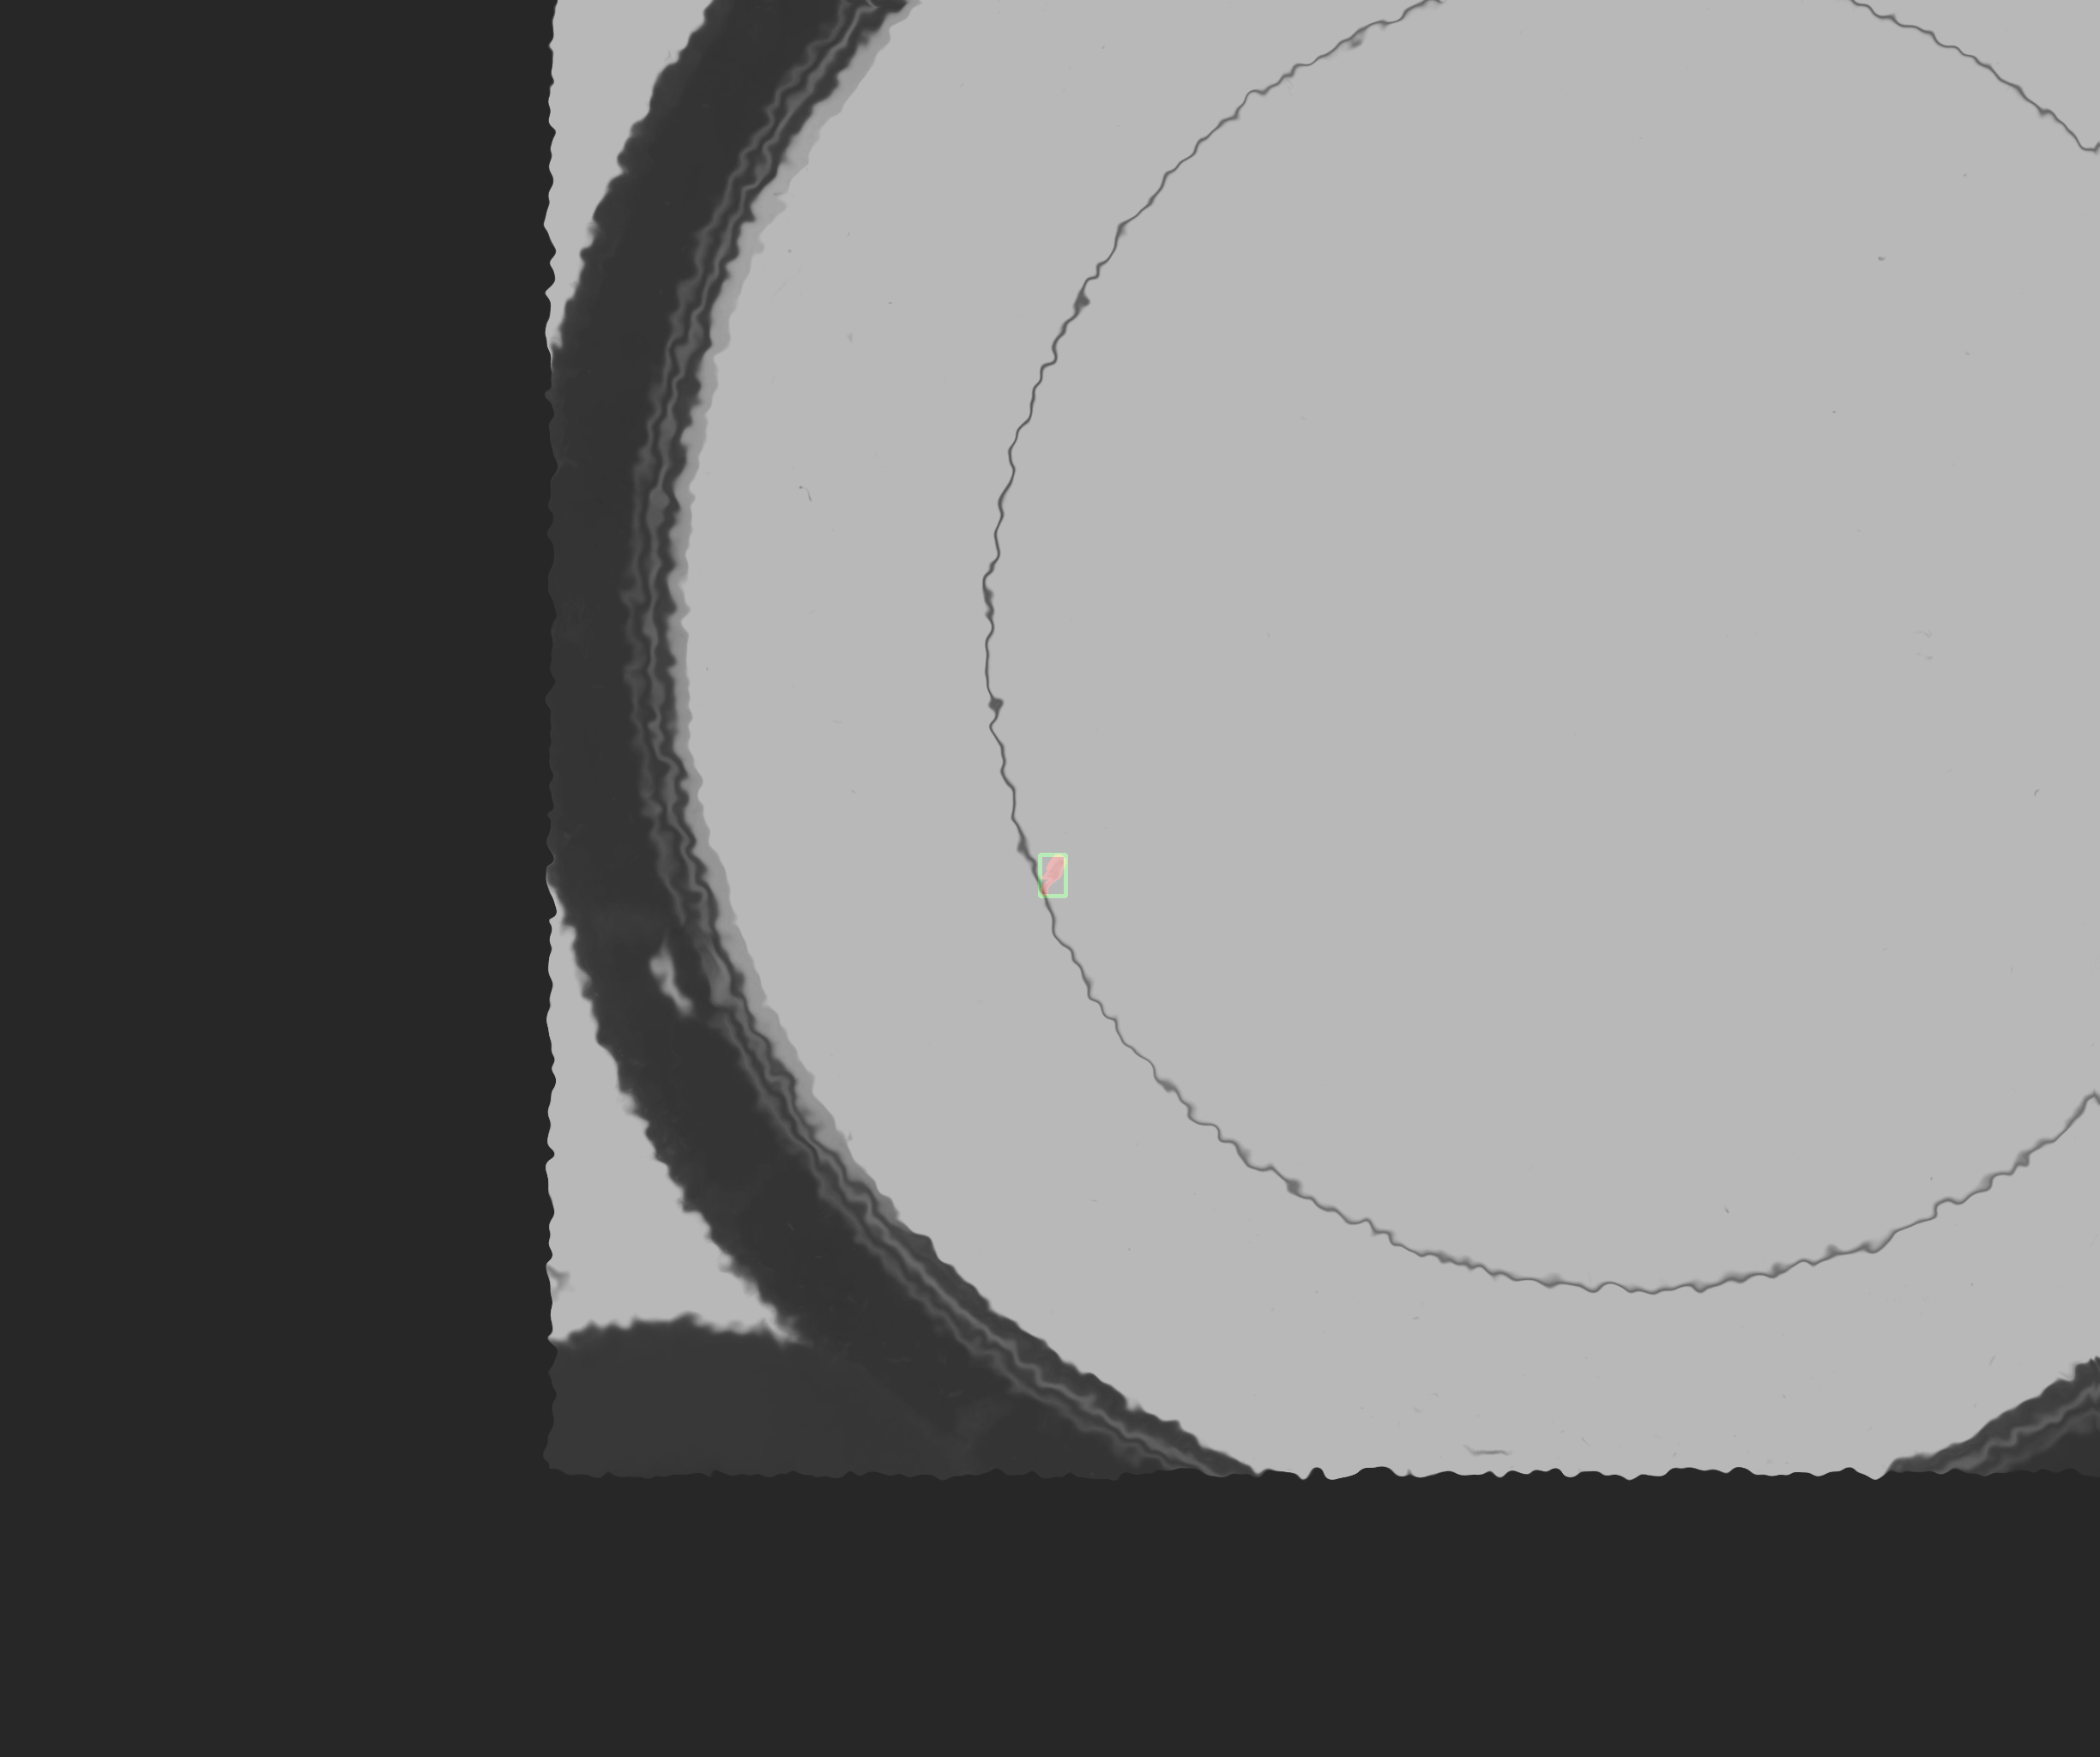

In [8]:
work_dir = './SYnthetic_data_generation_results/'+data_name+'/'
output_path =  work_dir +'augmented_defect_library/'
defect_annotation_file = output_path + 'augmented_training_defect_library_annotations.json'

image_path = output_path
annotation_file = defect_annotation_file 
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
img_name = sorted(list(annotations.keys()))[0] # check the first image  
image = np.array(Image.open(os.path.join(image_path, img_name+'.png')).convert('RGB'))
mask = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
for individual_defect_annotations in annotations[img_name]:
    x, y, w, h = individual_defect_annotations['bbox']
    p1, p2 = (int(x), int(y)), (int(x+w), int(y+h))
    mask[:, :, 1] = cv2.rectangle(mask[:, :, 1].copy(), p1, p2, color=255, thickness=4)
    seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation   
    mask[:, :, 0] = cv2.fillPoly(mask[:, :, 0].copy(), seg1, 255, lineType=cv2.LINE_AA)
color_mask = Image.fromarray(mask)
overlay = Image.blend(Image.fromarray(image), color_mask, 0.2)
display(overlay)

## Check the generated synthetic image visually

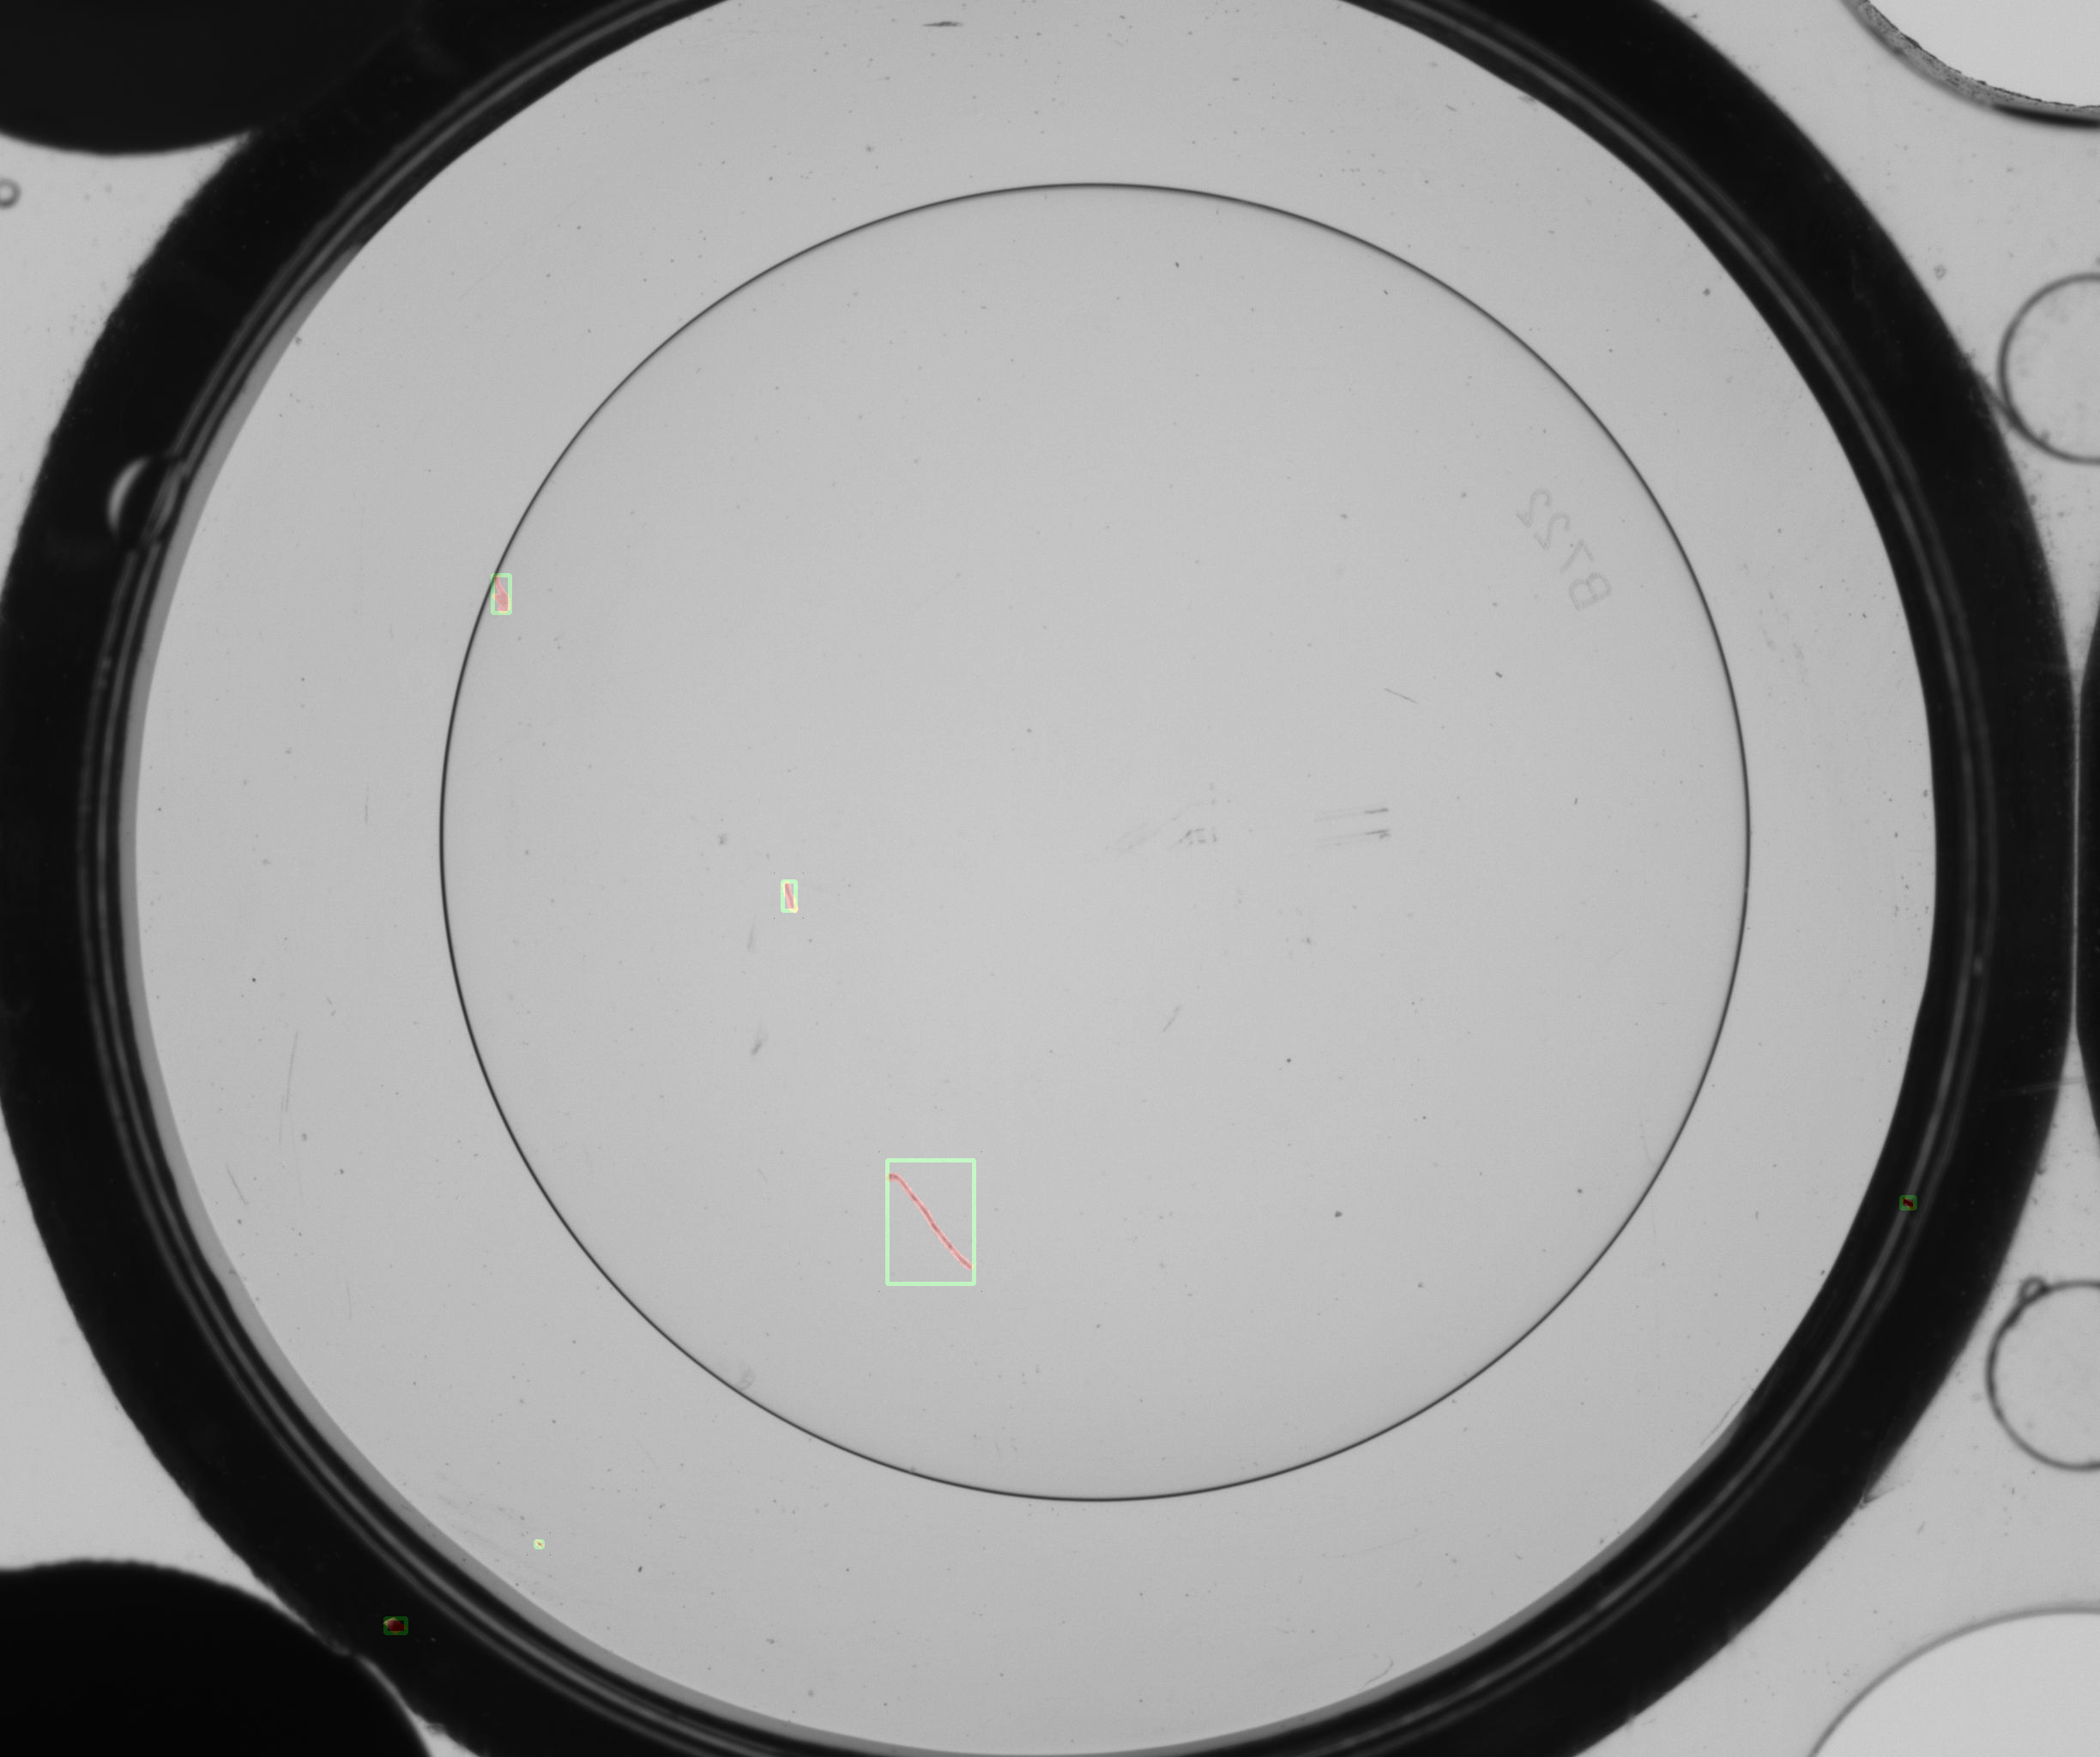

In [9]:
work_dir = './SYnthetic_data_generation_results/'+data_name+'/'
output_path = work_dir+'augmented_training_set/'
defect_annotation_file = output_path + 'generated_training_images_annotation.json'

image_path = output_path
annotation_file = defect_annotation_file 
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
img_name = sorted(list(annotations.keys()))[0]
image = np.array(Image.open(os.path.join(image_path, img_name)).convert('RGB'))
mask = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
for individual_defect_annotations in annotations[img_name]:
    x, y, w, h = individual_defect_annotations['bbox']
    p1, p2 = (int(x), int(y)), (int(x+w), int(y+h))
    mask[:, :, 1] = cv2.rectangle(mask[:, :, 1].copy(), p1, p2, color=255, thickness=4)
    seg1 = np.array([np.array(poly) for poly in individual_defect_annotations['segmentation']])# this has to be a list of arrays, each array is an annotation   
    mask[:, :, 0] = cv2.fillPoly(mask[:, :, 0].copy(), seg1, 255, lineType=cv2.LINE_AA)
color_mask = Image.fromarray(mask)
overlay = Image.blend(Image.fromarray(image), color_mask, 0.2)
display(overlay)

# Change 'augmented_training_defect_library_annotations.json' to coco format
The final coco version of generated synthetic defect dataset can be found at ```generated_synthetic_defect_dataset```.

In [11]:
# generate a dataframe that matches 
cats = coco.loadCats(coco.getCatIds())
cat_id = {}
for defect_type in cats:
    cat_id[defect_type['id']] = defect_type['name']
rows = []
defect_id = 0
images = sorted(list(annotations.keys()))
for image_id, image_name in enumerate(images):
    image = Image.open(os.path.join(image_path, image_name)).convert('RGB')
    defects = annotations[image_name]
    for defect in defects:
        mask = np.zeros((image.height, image.width)).astype(np.uint8)
        seg1 = [np.array(poly) for poly in defect['segmentation']]
        mask = cv2.fillPoly(mask, seg1, 255, lineType=cv2.LINE_AA)
        rows.append({
            'defect_id': defect_id,
            'image_id': image_id,
            'image_name':image_name, # I added a image name
            'category': cat_id[defect['category_id']],
            'category_id': defect['category_id'],
            'bbox': get_bbox_from_bool_mask(mask),
            'seg': get_coco_segmentation_from_bool_mask(mask),
        })
df = pd.DataFrame(rows)
train_imgs = sorted(list(annotations.keys()))
val_imges = []
# Generate Coco Style Annotation with Sahi
binarize = False
data_path = work_dir + 'generated_synthetic_defect_dataset/' # the generated images will be stored here
os.makedirs(data_path, exist_ok = True)
coco_train = Coco()
coco_valid = Coco()

if binarize:
    coco_train.add_category(CocoCategory(id=0, name='NG'))
    coco_valid.add_category(CocoCategory(id=0, name='NG'))
else:
    for i, category in cat_id.items():
        coco_train.add_category(CocoCategory(id=i, name=category))
        coco_valid.add_category(CocoCategory(id=i, name=category))

for image_id, image_name in enumerate(images):
    image = Image.open(os.path.join(image_path, image_name)).convert('RGB')
    coco_image = CocoImage(file_name=image_name, height=image.height, width=image.width)

    defects = df[df.image_name == image_name]
    for _, defect in defects.iterrows():
        # print(defect.bbox, defect.seg, defect.category_id, defect.category)
        if defect.bbox:
            coco_image.add_annotation(
                CocoAnnotation(
                    bbox=defect.bbox,
                    segmentation=defect.seg,
                    category_id=0 if binarize else defect.category_id,
                    category_name='NG' if binarize else defect.category
                )
            )
    if image_name in train_imgs:
        os.makedirs( os.path.join(data_path, 'train'), exist_ok = True)
        shutil.copy(os.path.join(image_path, image_name), os.path.join(data_path, 'train', image_name))
        coco_train.add_image(coco_image)
    # elif image_name in valid_imgs:
    #     os.makedirs( os.path.join(data_path, 'valid'), exist_ok = True)
    #     shutil.copy(os.path.join(image_path, image_name), os.path.join(data_path, 'valid', image_name))
    #     coco_valid.add_image(coco_image)
print(coco_train.stats["num_annotations_per_category"])
# print(coco_valid.stats["num_annotations_per_category"])
save_json(coco_train.json, os.path.join(data_path, 'train', '_annotations.coco.json'))
# save_json(coco_valid.json, os.path.join(data_path, 'valid', '_annotations.coco.json'))

{'Fiber': 1232, 'Hole': 109, 'Surface Damage': 873, 'Tear': 186}
